# 离群点分析与异常检测
使用Python工具包PyOD来检测多变量数据中的离群点。此处使用的是离群得分，即每个模型都会给每个数据点打分，而不是直接根据一个阈值判定某个点是否为离群点。
使用的检测算法有六种：Cluster-based Local Outlier Factor (CBLOF)、Feature Bagging、Histogram-base Outlier Detection (HBOS)、Isolation Forest、K Nearest Neighbors (KNN)、Average KNN。
### Cluster-based Local Outlier Factor (CBLOF)
CBLOF将数据分为小型集群和大型集群。 然后根据点所属的簇的大小以及到最近的大簇的距离来计算异常分数。
### Feature Bagging
Feature Bagging在数据集的各种子样本上安装了许多基本检测器。 它使用平均或其他组合方法来提高预测精度。首先通过随机选择特征子集来构造n个子样本。 这带来了基本估计的多样性。 最后，通过平均或取所有基本检测器的最大值来生成预测分数。
### Histogram-base Outlier Detection (HBOS)
HBOS是一种有效的无监督方法，它假设特征独立并通过构建直方图来计算异常值。
### Isolation Forest
Isolation Forest在内部使用scikit-learn库。在此方法中，使用一组树完成数据分区。隔离森林提供了一个异常分数，用于查看结构中点的隔离程度。 然后使用异常分数来识别来自正常观察的异常值。
### K Nearest Neighbors (KNN)
在KNN中，对于任何数据点，到第k个最近邻居的距离可以被视为远离分数。
### Average KNN


## 数据集——skin

首先引入需要依赖的库。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.preprocessing import MinMaxScaler


C:\Users\xue\Anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


读取skin数据集，使用pandas读取。此处以skin数据集中的benchmarks文件夹中的skin_benchmark_0001.csv文件为例进行离群点分析与异常检测。

In [2]:
path = 'E:/课程_研一下/数据挖掘/课后作业/12/skin/benchmarks/skin_benchmark_0001.csv'
df = pd.read_csv(path, header=0, index_col=None, engine='python', encoding='utf-8')

此处将所选属性的范围转换至[0,1]，避免数值范围不同导致的分析误差。此处我们以数据集中的属性R和G为例，进行离群点分析与异常检测。

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[['R', 'G']] = scaler.fit_transform(df[['R', 'G']])

从DataFrame类型中取出values，将这些值存储在NumPy数组，并对其进行连接。

In [6]:
X1 = df['R'].values.reshape(-1, 1)
X2 = df['G'].values.reshape(-1, 1)
X = np.concatenate((X1, X2), axis=1)

创建一个字典，将离群点检测的名称和模型存入字典。将异常分数的值设置为0.05。

In [10]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.05
# Define seven outlier detection tools to be compared
classifiers = {
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}


逐个拟合每个模型的数据，查看每个模型预测异常值的结果。最小异常值到阈值的范围填充为蓝色，在异常分数等于阈值处绘制红色等高线，异常值范围为阈值到最大异常值的范围填充为填充为橙色。从实验结果可以看到，从绘制的表格中可以看到离群点和非离群点。
在Cluster-based Local Outlier Factor (CBLOF)方法中，离群点数量为300，非离群点数量为5700；
在Feature Bagging方法中，离群点数量为227，非离群点数量为5773；
在Histogram-base Outlier Detection (HBOS)方法中，离群点数量为218，非离群点数量为5782；
在Isolation Forest方法中，离群点数量为293，非离群点数量为5707；
在K Nearest Neighbors (KNN)方法中，离群点数量为243，非离群点数量为5757；
在Average KNN方法中，离群点数量为172，非离群点数量为5828。

OUTLIERS :  300 INLIERS :  5700 Cluster-based Local Outlier Factor (CBLOF)


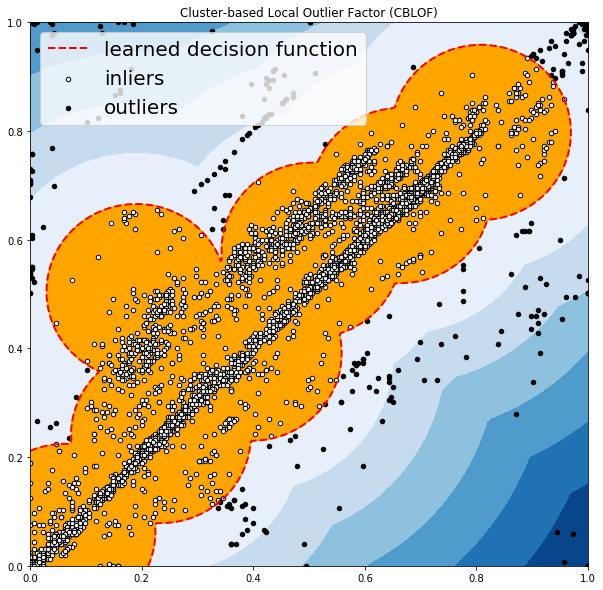

OUTLIERS :  227 INLIERS :  5773 Feature Bagging


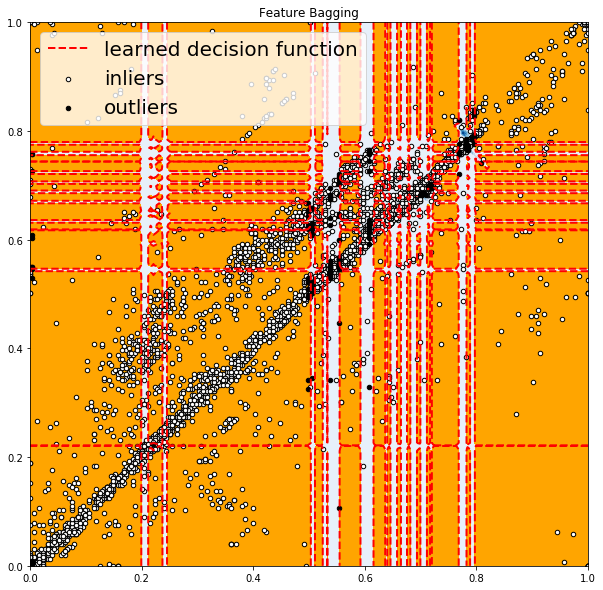

OUTLIERS :  218 INLIERS :  5782 Histogram-base Outlier Detection (HBOS)


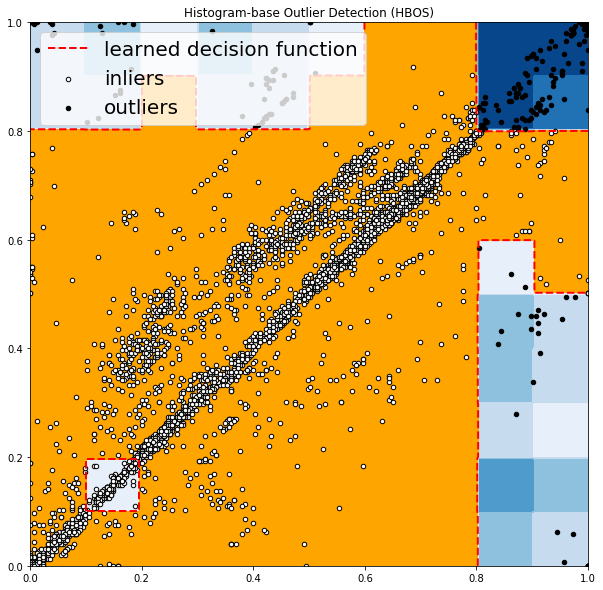

OUTLIERS :  293 INLIERS :  5707 Isolation Forest


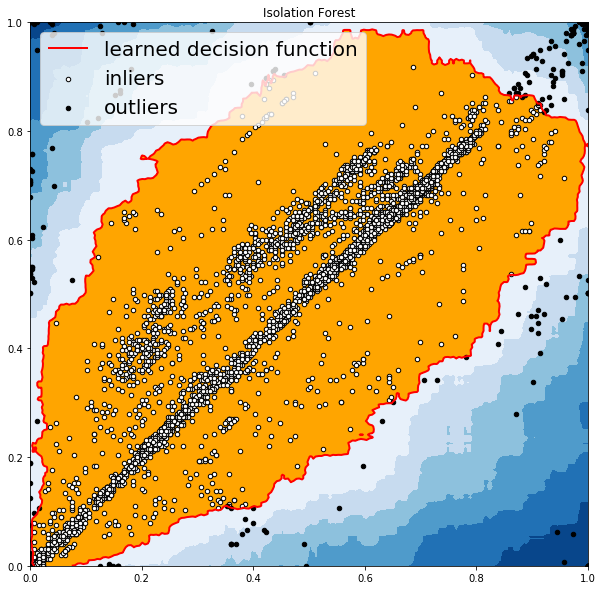

OUTLIERS :  243 INLIERS :  5757 K Nearest Neighbors (KNN)


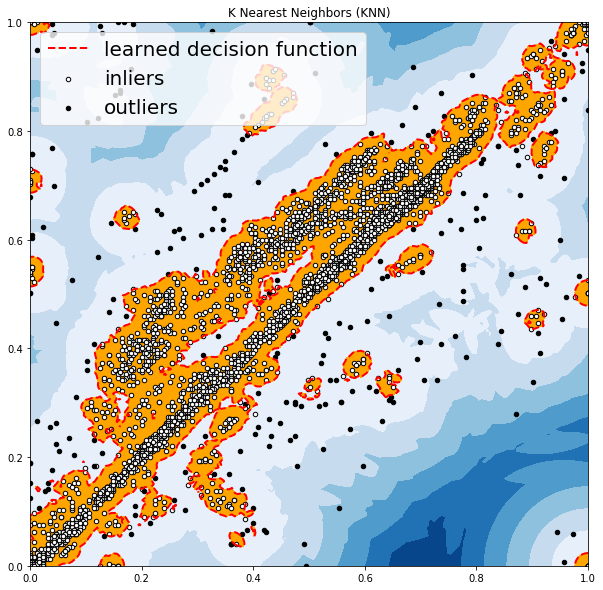

OUTLIERS :  172 INLIERS :  5828 Average KNN


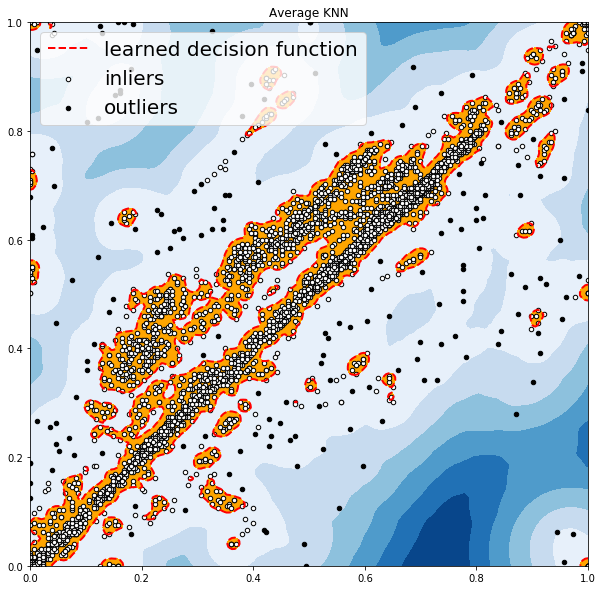

In [11]:
xx, yy = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score，预测原始异常值
    scores_pred = clf.decision_function(X) * -1

    # prediction of a datapoint category outlier or inlier，数据点类别的预测，离群值或非离群值
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))

    # copy of dataframe
    dfx = df
    dfx['outlier'] = y_pred.tolist()

    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 = np.array(dfx['R'][dfx['outlier'] == 0]).reshape(-1, 1)
    IX2 = np.array(dfx['G'][dfx['outlier'] == 0]).reshape(-1, 1)

    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 = dfx['R'][dfx['outlier'] == 1].values.reshape(-1, 1)
    OX2 = dfx['G'][dfx['outlier'] == 1].values.reshape(-1, 1)

    print('OUTLIERS : ', n_outliers, 'INLIERS : ', n_inliers, clf_name)

    # threshold value to consider a datapoint inlier or outlier
    threshold = scipy.stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)

    # decision function calculates the raw anomaly score for every point
    # 决策函数计算每个点的原始异常值
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    # fill blue map colormap from minimum anomaly score to threshold value
    # 填充从最小异常值到阈值的蓝色图颜色图
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r)

    # draw red contour line where anomaly score is equal to thresold
    # 在异常分数等于阈值处绘制红色等高线
    a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    # 填充橙色的等值线，其中异常值范围为阈值到最大异常值
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')
    b = plt.scatter(IX1, IX2, c='white', s=20, edgecolor='k')
    c = plt.scatter(OX1, OX2, c='black', s=20, edgecolor='k')
    plt.axis('tight')

    # loc=2 is used for the top left corner
    plt.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'inliers', 'outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)

    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()

## 数据集——wine

首先引入需要依赖的库。

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.preprocessing import MinMaxScaler


读取wine数据集，使用pandas读取。此处以wine数据集中的benchmarks文件夹中的wine_benchmark_0001.csv文件为例进行离群点分析与异常检测。

In [14]:
path = 'E:/课程_研一下/数据挖掘/课后作业/12/wine/benchmarks/wine_benchmark_0001.csv'
df = pd.read_csv(path, header=0, index_col=None, engine='python', encoding='utf-8')

此处将所选属性的范围转换至[0,1]，避免数值范围不同导致的分析误差。此处我们以数据集中的属性R和G为例，进行离群点分析与异常检测。

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[['fixed.acidity', 'pH']] = scaler.fit_transform(df[['fixed.acidity', 'pH']])

从DataFrame类型中取出values，将这些值存储在NumPy数组，并对其进行连接。

In [17]:
X1 = df['fixed.acidity'].values.reshape(-1, 1)
X2 = df['pH'].values.reshape(-1, 1)
X = np.concatenate((X1, X2), axis=1)

创建一个字典，将离群点检测的名称和模型存入字典。将异常分数的值设置为0.05。

In [18]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.05
# Define seven outlier detection tools to be compared
classifiers = {

        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

逐个拟合每个模型的数据，查看每个模型预测异常值的结果。最小异常值到阈值的范围填充为蓝色，在异常分数等于阈值处绘制红色等高线，异常值范围为阈值到最大异常值的范围填充为填充为橙色。从实验结果可以看到，从绘制的表格中可以看到离群点和非离群点。
在Cluster-based Local Outlier Factor (CBLOF)方法中，离群点数量为186，非离群点数量为3517；
在Feature Bagging方法中，离群点数量为166，非离群点数量为3537；
在Histogram-base Outlier Detection (HBOS)方法中，离群点数量为181，非离群点数量为3522；
在Isolation Forest方法中，离群点数量为186，非离群点数量为3517；
在K Nearest Neighbors (KNN)方法中，离群点数量为146，非离群点数量为3557；
在Average KNN方法中，离群点数量为87，非离群点数量为3616；

OUTLIERS :  186 INLIERS :  3517 Cluster-based Local Outlier Factor (CBLOF)


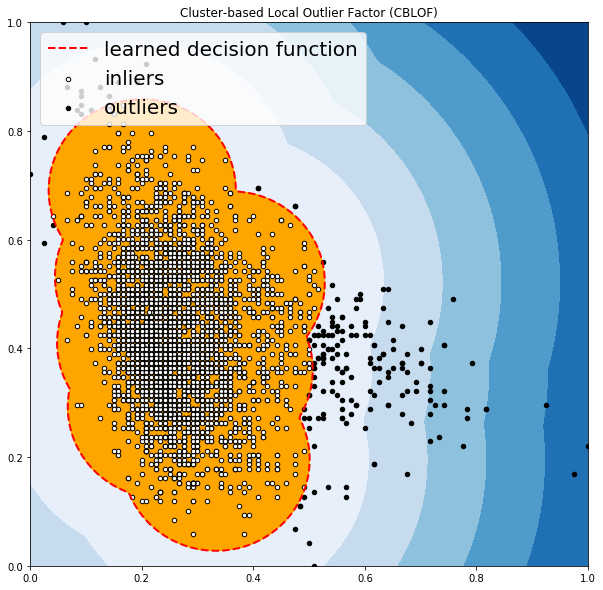

OUTLIERS :  166 INLIERS :  3537 Feature Bagging


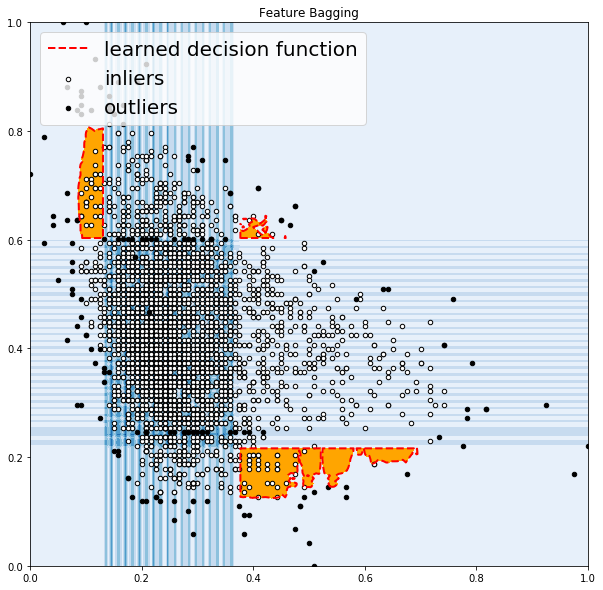

OUTLIERS :  181 INLIERS :  3522 Histogram-base Outlier Detection (HBOS)


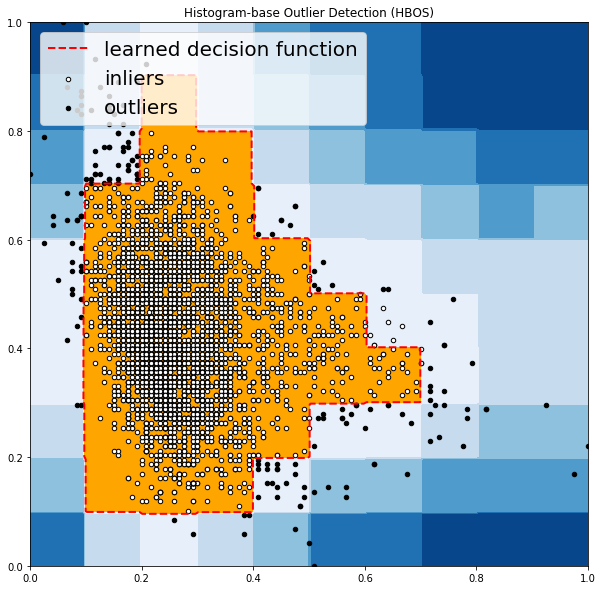

OUTLIERS :  186 INLIERS :  3517 Isolation Forest


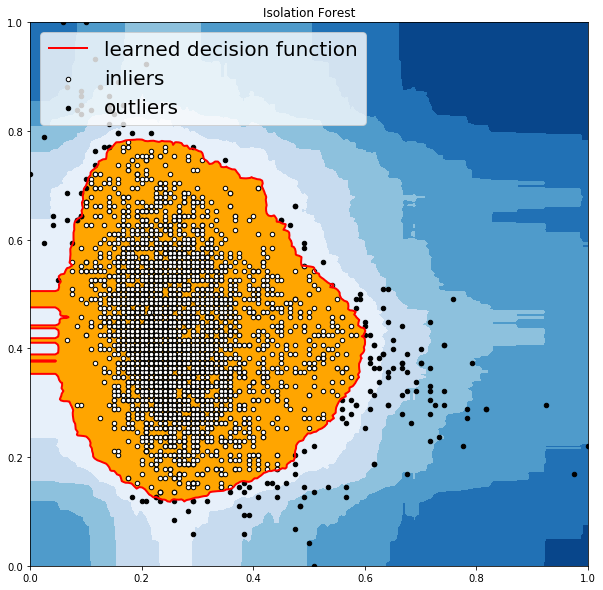

OUTLIERS :  146 INLIERS :  3557 K Nearest Neighbors (KNN)


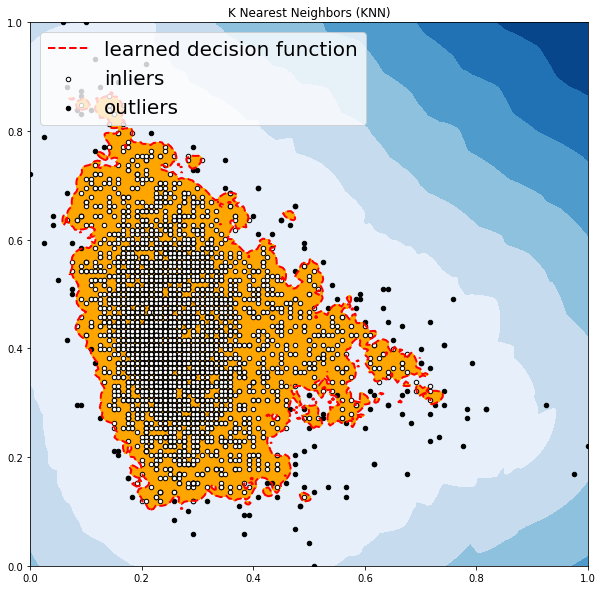

OUTLIERS :  87 INLIERS :  3616 Average KNN


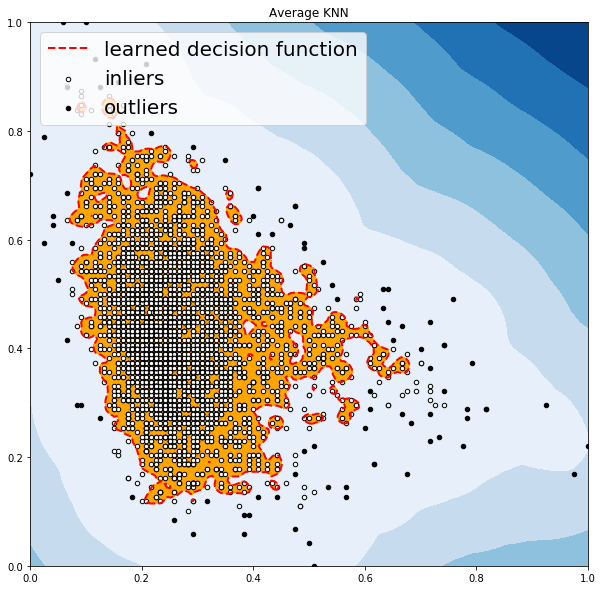

In [19]:
xx, yy = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score，预测原始异常值
    scores_pred = clf.decision_function(X) * -1

    # prediction of a datapoint category outlier or inlier，数据点类别的预测，离群值或非离群值
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))

    # copy of dataframe
    dfx = df
    dfx['outlier'] = y_pred.tolist()

    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 = np.array(dfx['fixed.acidity'][dfx['outlier'] == 0]).reshape(-1, 1)
    IX2 = np.array(dfx['pH'][dfx['outlier'] == 0]).reshape(-1, 1)

    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 = dfx['fixed.acidity'][dfx['outlier'] == 1].values.reshape(-1, 1)
    OX2 = dfx['pH'][dfx['outlier'] == 1].values.reshape(-1, 1)

    print('OUTLIERS : ', n_outliers, 'INLIERS : ', n_inliers, clf_name)

    # threshold value to consider a datapoint inlier or outlier
    threshold = scipy.stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)

    # decision function calculates the raw anomaly score for every point
    # 决策函数计算每个点的原始异常值
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    # fill blue map colormap from minimum anomaly score to threshold value
    # 填充从最小异常值到阈值的蓝色图颜色图
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r)

    # draw red contour line where anomaly score is equal to thresold
    # 在异常分数等于阈值处绘制红色等高线
    a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    # 填充橙色的等值线，其中异常值范围为阈值到最大异常值
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')
    b = plt.scatter(IX1, IX2, c='white', s=20, edgecolor='k')
    c = plt.scatter(OX1, OX2, c='black', s=20, edgecolor='k')
    plt.axis('tight')

    # loc=2 is used for the top left corner
    plt.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'inliers', 'outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)

    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()
